In [1]:
import tensorflow as tf
import os
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import pandas as pd

In [2]:
train_dir = '/Users/nidhipareddy/Desktop/uchicago/Computer Vision/ai_art_classification/train'
test_dir = '/Users/nidhipareddy/Desktop/uchicago/Computer Vision/ai_art_classification/test'

In [3]:
# Parameters
img_size = (224, 224)
batch_size = 32
seed = 42

# Load training and validation datasets
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Found 18618 files belonging to 2 classes.
Using 14895 files for training.
Found 18618 files belonging to 2 classes.
Using 3723 files for validation.


In [4]:
# Create the model
base_model = EfficientNetB1(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [5]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 948s 2s/step - accuracy: 0.7887 - loss: 0.4453 - val_accuracy: 0.8791 - val_loss: 0.2886 - learning_rate: 0.0010
Epoch 2/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 894s 2s/step - accuracy: 0.8593 - loss: 0.3244 - val_accuracy: 0.8880 - val_loss: 0.2739 - learning_rate: 0.0010
Epoch 3/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 917s 2s/step - accuracy: 0.8654 - loss: 0.3090 - val_accuracy: 0.8853 - val_loss: 0.2685 - learning_rate: 0.0010
Epoch 4/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 920s 2s/step - accuracy: 0.8692 - loss: 0.3075 - val_accuracy: 0.8885 - val_loss: 0.2655 - learning_rate: 0.0010
Epoch 5/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 877s 2s/step - accuracy: 0.8731 - loss: 0.3041 - val_accuracy: 0.8904 - val_loss: 0.2669 - learning_rate: 0.0010
Epoch 6/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 919s 2s/step - accuracy: 0.8712 - loss: 0.3038 - val_accuracy: 0.8885 - val_loss: 0.2641 - learning_rate: 0.0010
Epoch 7/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 934s 2s/step - accuracy: 0.8745 - loss: 0.

In [6]:
base_model.trainable = True
fine_tune_at = 100 

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 680s 1s/step - accuracy: 0.8415 - loss: 0.3604 - val_accuracy: 0.8845 - val_loss: 0.2801 - learning_rate: 1.0000e-05
Epoch 2/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - accuracy: 0.8833 - loss: 0.2790 - val_accuracy: 0.9006 - val_loss: 0.2483 - learning_rate: 1.0000e-05
Epoch 3/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 724s 2s/step - accuracy: 0.9010 - loss: 0.2490 - val_accuracy: 0.9046 - val_loss: 0.2344 - learning_rate: 1.0000e-05
Epoch 4/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 725s 2s/step - accuracy: 0.9053 - loss: 0.2230 - val_accuracy: 0.9092 - val_loss: 0.2206 - learning_rate: 1.0000e-05
Epoch 5/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 715s 2s/step - accuracy: 0.9085 - loss: 0.2104 - val_accuracy: 0.9122 - val_loss: 0.2123 - learning_rate: 1.0000e-05
Epoch 6/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 720s 2s/step - accuracy: 0.9218 - loss: 0.1950 - val_accuracy: 0.9181 - val_loss: 0.2006 - learning_rate: 1.0000e-05
Epoch 7/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 712s 2s/step - acc

In [7]:
# --- Predict on Test Set ---
test_files = sorted([os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.jpg')])

def preprocess_image(path):
    img = tf.keras.preprocessing.image.load_img(path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

predictions = []
for path in test_files:
    img = preprocess_image(path)
    pred = model.predict(img)
    predictions.append(pred[0][0])

submission = pd.DataFrame({
    'filename': [os.path.basename(x) for x in test_files],
    'AI_Prob': predictions
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━

In [8]:
submission['Prediction'] = submission['AI_Prob'].apply(lambda x: 1 if x > 0.5 else 0)  # 1 = AI_GENERATED, 0 = NON_AI_GENERATED

submission.to_csv('submission.csv', index=False)

print(submission.head())

   filename   AI_Prob  Prediction
0     0.jpg  0.556758           1
1     1.jpg  0.920448           1
2    10.jpg  0.999161           1
3   100.jpg  0.106958           0
4  1000.jpg  0.847739           1


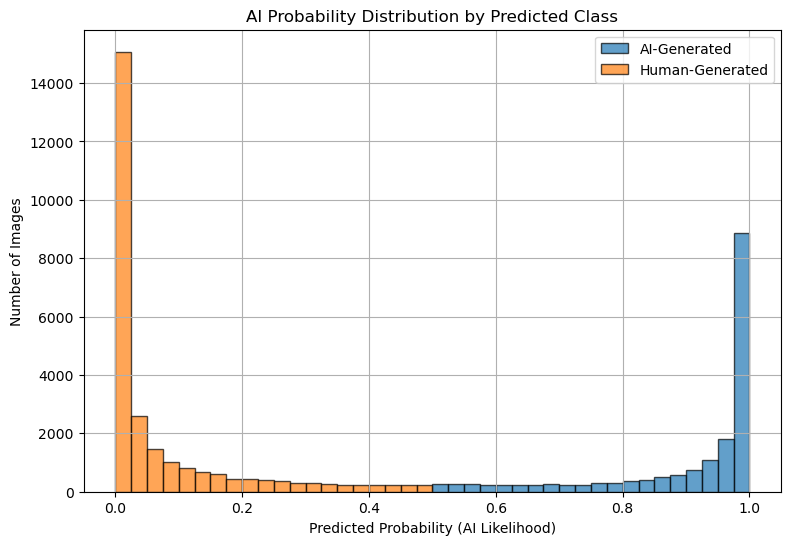

In [10]:
# Split data into two groups
ai_generated = submission[submission['Prediction'] == 1]['AI_Prob']
human_generated = submission[submission['Prediction'] == 0]['AI_Prob']

# Plot both distributions
plt.figure(figsize=(9,6))
plt.hist(ai_generated, bins=20, alpha=0.7, label='AI-Generated', edgecolor='black')
plt.hist(human_generated, bins=20, alpha=0.7, label='Human-Generated', edgecolor='black')
plt.title('AI Probability Distribution by Predicted Class')
plt.xlabel('Predicted Probability (AI Likelihood)')
plt.ylabel('Number of Images')
plt.legend()
plt.grid(True)
plt.show()

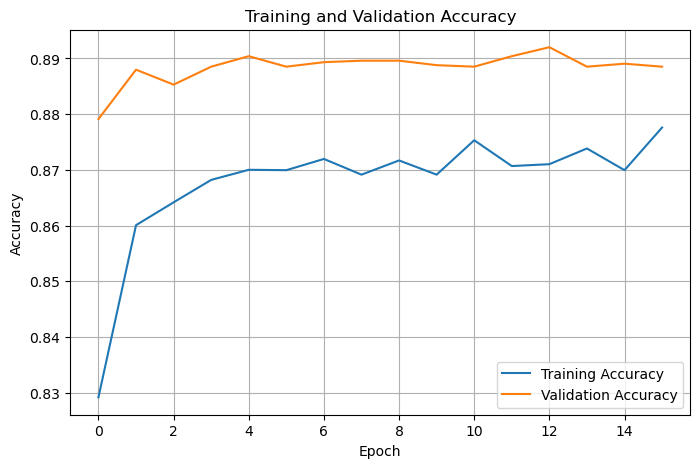

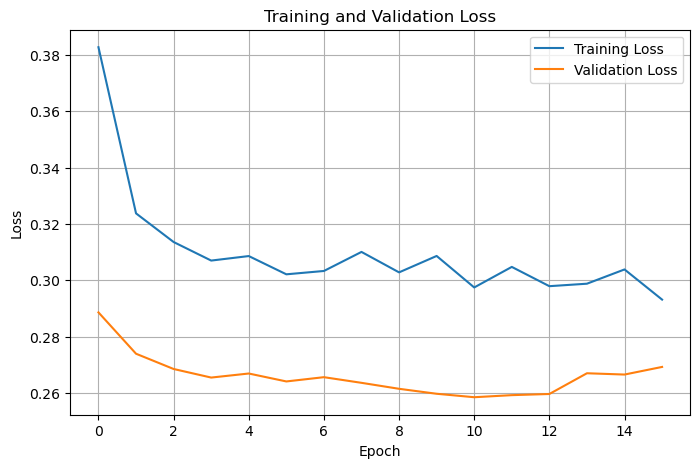

In [11]:
import matplotlib.pyplot as plt

# --- Accuracy plot ---
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# --- Loss plot ---
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

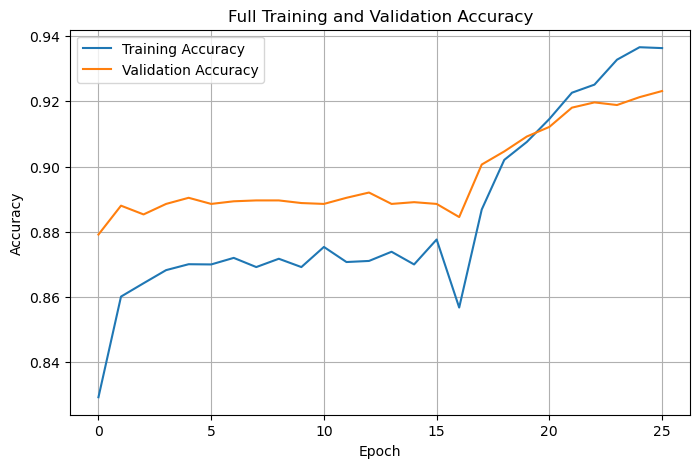

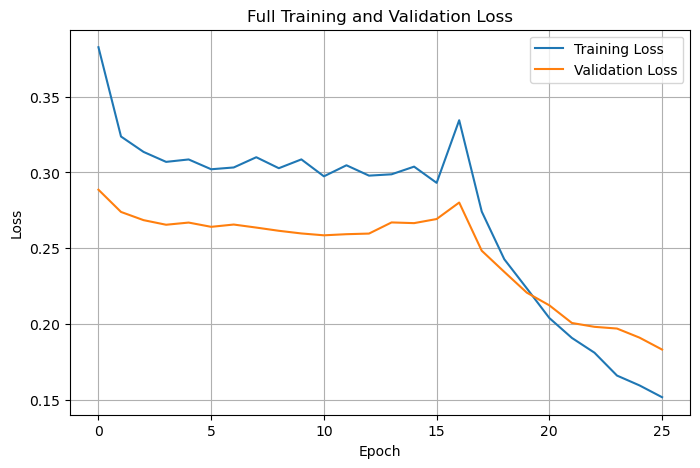

In [12]:
# Combine training histories
full_accuracy = history.history['accuracy'] + fine_tune_history.history['accuracy']
full_val_accuracy = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
full_loss = history.history['loss'] + fine_tune_history.history['loss']
full_val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

# Plot
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(8,5))
plt.plot(full_accuracy, label='Training Accuracy')
plt.plot(full_val_accuracy, label='Validation Accuracy')
plt.title('Full Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,5))
plt.plot(full_loss, label='Training Loss')
plt.plot(full_val_loss, label='Validation Loss')
plt.title('Full Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
model.save('ai_art_detector.h5')